# The Bayesian framework using minimization of weights

## Simulated data

In [56]:
from scipy import optimize
from scipy.interpolate import interp1d
import pickle
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pdb

# load the filename list
#fns = glob.glob('../../Data/LUT/lhd300_validate_ap/20/30/45/*.p')
fns = ['../../Data/LUT/lhd1000_valid_ap_realistic/40_54_52_1.85958871_0.15750657_26.89028313_1022.28958805_0.32186472_0.591295.p']

print 'loading file: %s' % fns[0]

wl_min = 680.
wl_max = 755.


loading file: ../../Data/LUT/lhd1000_valid_ap_realistic/40_54_52_1.85958871_0.15750657_26.89028313_1022.28958805_0.32186472_0.591295.p


solver success: True
J cost: 82.7342
RMSE:   0.0013
sza: 40.0, vza: 54.0, raa: 52.0, alt: 1.85958871 km
--------------------------------------------------
True parameters
clf: 0.1000, AOT: 0.1575, WVC: 26.8903 kg/m2, press: 1022.2896 hPa, a: 0.3219, p: 0.5913, DASF: 0.7875
--------------------------------------------------
Prior parameters (mean, std)
clf: 0.0800, AOT: 0.1700, WVC: 28.0000 kg/m2, press: 1020.0000 hPa, a: 0.5000, p: 0.5000
std: 0.0200, std: 0.0500, std:  2.2000 kg/m2, std:      2.0000 hPa,std:1.4142,std:1.4142
--------------------------------------------------
Retrieved parameters (mean, std)
clf: 0.0799, AOT: 0.4171, WVC: 28.7387 kg/m2, press: 1023.0670 hPa, a: 0.3510, p: 0.5727, DASF: 0.8214
std: 0.0085, std: 0.0383, std:  0.2052 kg/m2, std:      1.9491 hPa,std:0.0053,std:0.0021
--------------------------------------------------
Simple solution (mean, std)
                                                                    a: 0.3137, p: 0.5269, DASF: 0.6631
          

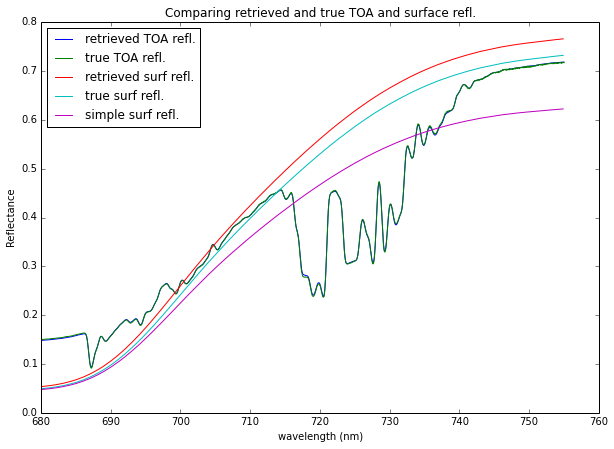

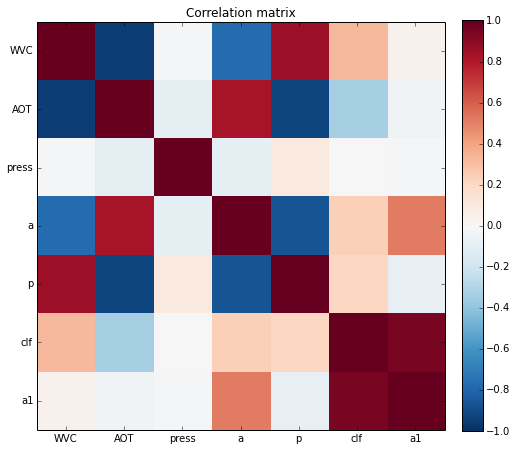

In [57]:
dic = pickle.load(open(fns[0], 'rb'))

# cloud fraction to use
clf = 0.10

# priors variances are based on the following:
# MODIS AOD +-0.05 +-0.02*tau (Chu et al. 2002)
# MODIS WV std 2.2mm (Li, Muller & Cross, 2003)
# NCEP press unknown...
# FRESCO vs FRESCO+ clf std 0.023 (Tuinder et al 2010) but expected accuracy <10% (Valks et al 2013)

AOT_prior = 0.17
AOT_var = (0.05)**2
WVC_prior = 28.
WVC_var = (2.2)**2
press_prior = 1020.
press_var = (2.0)**2
clf_prior = 0.08
clf_var = (0.02)**2
a_prior = 0.5
a_var = 2.
p_prior = 0.5
p_var = 2.
a1_prior = -30
a1_var = 10

# round to closest value
sza = dic['sol_zen']
vza = dic['sat_zen']
raa = dic['rel_azi']
alt = dic['alt']
AOT = dic['AOT']
WVC = dic['WVC']
press = dic['press']
a = dic['a']
p = dic['p']
szar = int(round(sza, -1))
vzar = int(round(vza, -1))
raas = range(0, 195, 15)
raar = min(raas, key=lambda x:abs(x-raa))
toa_refl = dic['toa_refl']
lam = dic['lam']
lam_emu = lam[np.logical_and(lam>=wl_min, lam<=wl_max)]

# adding clouds
import pandas as pd
fn = 'cloud_sims.h5'
cld_type = 'Cu'
cld_df = pd.read_hdf(fn, key='reflectance')
cld_lam = cld_df[cld_type].icol(0).index.values
cld_ref = cld_df[cld_type].icol(0).values
cld_ref = cld_ref[np.logical_and(cld_lam>=wl_min, cld_lam<=wl_max)]

# add the uncorrelated noise
# use convention of SNR = expected signal / std of noise
snr = 1000 # see sources above
std_noise = cld_ref / snr
rand_noise = np.random.normal(0., std_noise)
cld_ref += rand_noise

# refl to gome
toa_refl_gome = toa_refl[np.logical_and(lam>=wl_min, lam<=wl_max)]
std_noise = toa_refl_gome / snr
rand_noise = np.random.normal(0., std_noise)
toa_refl_gome += rand_noise

# combine atmosphere and cloud signal
toa_refl_gome = toa_refl_gome * (1. - clf) + cld_ref * clf

# import cloud PCA
h5_fn = 'cloud_sims.h5'
pca_red_df = pd.read_hdf(h5_fn, key='pca_red_edge')

pca_lam = np.array(pca_red_df.index)
pcas = pca_red_df.values.T

import gp_emulator
h5_emu = '/home/malapradej/Documents/PhD_UCL/Data/LUT/libradtran_emulators_680-755.h5'
emu = gp_emulator.MultivariateEmulator(dump=h5_emu, model='toa_refl', sza=szar, vza=vzar, raa=raar)
basis = emu.basis_functions

import h5py
h5_mean = h5py.File('/home/malapradej/Documents/PhD_UCL/Data/LUT/mean_signal.h5', 'r')
grp = '%s_%s_%s' % (szar, vzar, raar)
grp = h5_mean[grp]
mean_toa_refl = grp['mean_toa_refl'][:]
mean_toa_refl = mean_toa_refl[np.logical_and(lam>=wl_min, lam<=wl_max)]

# get prior for observation weights
# wt_priors = np.dot(basis, (toa_refl_gome - mean_toa_refl))

def cost(paras, sza, vza, raa, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVCe, WVCv, AOTe, AOTv,\
         presse, pressv, ae, av, pe, pv, clfe, clfv, a1e, a1v):
    '''The cost function to minimize the log of the probabilities
    '''
    WVC = paras[0]
    AOT = paras[1]
    press = paras[2]
    a = paras[3]
    p = paras[4]
    clf = paras[5]
    a1 = paras[6]
    paras = (WVC, AOT, alt, press, a, p)
    toa_refl_emu = emu.predict(paras)[0] # + mean_toa_refl
    # get refls to same wavelenghts
    from scipy.interpolate import interp1d
    # instead of comparing toa refl including cloud need to subtract cloud influence from gome spectra
    # also subtract mean spectra in training data (see notes on 13/12/15)
    toa_refl_comp = (toa_refl_gome - clf*a1*pcas[0]) / (1. - clf) - mean_toa_refl
    # calculate weights of the model and observation
    w = []
    m = []
    for i in range(emu.n_pcs):
        w.append(np.dot(toa_refl_comp, basis[i]))
        m.append(np.dot(toa_refl_emu, basis[i]))
    w = np.array(w)
    m = np.array(m)
    # forward model J term. need to calculate variance of the weights
    modvar = [np.mean(basis[i]**2*toa_refl_comp**2) - np.mean(basis[i]*toa_refl_comp)**2\
              for i in range(emu.n_pcs)]
    modvar = np.array(modvar)
    Jmod = 0.5*np.dot((w - m)**2, 1./modvar)
    # WVC J term
    Jwvc = 0.5*(WVC - WVCe)**2./WVCv
    # AOT J term
    Jaot = 0.5*(AOT - AOTe)**2./AOTv
    # press J term
    Jpress = 0.5*(press - presse)**2./pressv
    # a J term
    Ja = 0.5*(a - ae)**2./av
    # p J term
    Jp = 0.5*(p - pe)**2./pv
    # clf J term
    Jclf = 0.5*(clf - clfe)**2./clfv
    # a1 J term
    Ja1 = 0.5*(a1 - a1e)**2./a1v
    J = Jmod + Jwvc + Jaot + Jpress + Ja + Jp + Jclf + Ja1
    
    return J


# def jacob(paras, sza, vza, raa, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVCe, WVCv, AOTe, AOTv,\
#          presse, pressv, ae, av, pe, pv, clfe, clfv, a1e, a1v):
#     '''The jacobian of the cost function to minimize the log of the probabilities
#     '''
#     WVC = paras[0]
#     AOT = paras[1]
#     press = paras[2]
#     a = paras[3]
#     p = paras[4]
#     clf = paras[5]
#     a1 = paras[6]
#     paras = (WVC, AOT, alt, press, a, p)
#     toa_refl_emu, Mprime = emu.predict(paras) # + mean_toa_refl
#     # get refls to same wavelenghts
#     from scipy.interpolate import interp1d
#     # instead of comparing toa refl including cloud need to subtract cloud influence from gome spectra
#     # also subtract mean spectra in training data (see notes on 13/12/15)
# #     toa_refl_comp = (toa_refl_gome - clf*a1*pcas[0]) / (1. - clf) - mean_toa_refl
# #     # calculate weights of the model and observation
# #     w = []
# #     m = []
# #     for i in range(emu.n_pcs):
# #         w.append(np.dot(toa_refl_comp, basis[i]))
# #         m.append(np.dot(toa_refl_emu, basis[i]))
# #     w = np.array(w)
# #     m = np.array(m)
# #     # forward model jacobian. need to calculate variance of the weights
# #     modvar = [np.mean(basis[i]**2*toa_refl_comp**2) - np.mean(basis[i]*toa_refl_comp)**2\
# #               for i in range(emu.n_pcs)]
# #     modvar = np.array(modvar)
# #     jmod = np.dot((w - m), 1./modvar)
    
#     # obs jacobian
#     jobs = Mprime.dot(basis.T)
#     jobs = np.sum(jobs, axis=1)
    
#     # WVC jacobian
#     jwvc = (WVC - WVCe)/WVCv + jobs[0]
#     # AOT jacobian
#     jaot = (AOT - AOTe)/AOTv + jobs[1]
#     # press jacobian
#     jpress = (press - presse)/pressv + jobs[3]
#     # a jacobian
#     ja = (a - ae)/av + jobs[4]
#     # p jacobian
#     jp = (p - pe)/pv + jobs[5]
#     # clf jacobian
#     jclf = (clf - clfe)/clfv
#     # a1 jacobian
#     ja1 = (a1 - a1e)/a1v

#     return np.array([jwvc, jaot, jpress, ja, jp, jclf, ja1])

# def hess(paras, sza, vza, raa, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVCe, WVCv, AOTe, AOTv,\
#          presse, pressv, ae, av, pe, pv, clfe, clfv, a1e, a1v):
#     '''The hessian of the cost function to minimize the log of the probabilities
#     '''
#     WVC = paras[0]
#     AOT = paras[1]
#     press = paras[2]
#     a = paras[3]
#     p = paras[4]
#     clf = paras[5]
#     a1 = paras[6]
#     paras = (WVC, AOT, alt, press, a, p)
#     toa_refl_emu, Mprime = emu.predict(paras) # + mean_toa_refl
#     # get refls to same wavelenghts
#     from scipy.interpolate import interp1d
#     a0 = 1. / (1. - clf)
#     # instead of comparing toa refl including cloud need to subtract cloud influence from gome spectra
#     # also subtract mean spectra in training data (see notes on 13/12/15)
#     toa_refl_comp = (toa_refl_gome - clf*a1*pcas[0]) / (1. - clf) - mean_toa_refl
#     # calculate weights of the model and observation
#     w = []
#     m = []
#     for i in range(emu.n_pcs):
#         w.append(np.dot(toa_refl_comp, basis[i]))
#         m.append(np.dot(toa_refl_emu, basis[i]))
#     w = np.array(w)
#     m = np.array(m)
#     # forward model jacobian. need to calculate variance of the weights
#     modvar = [np.mean(basis[i]**2*toa_refl_comp**2) - np.mean(basis[i]*toa_refl_comp)**2\
#               for i in range(emu.n_pcs)]
#     modvar = np.array(modvar)
#     hmod = 1. / modvar
#     # WVC jacobian
#     hwvc = 1./WVCv
#     # AOT jacobian
#     haot = 1./AOTv
#     # press jacobian
#     hpress = 1./pressv
#     # a jacobian
#     ha = 1./av
#     # p jacobian
#     hp = 1./pv
#     # clf jacobian
#     hclf = 1./clfv
#     # a1 jacobian
#     ha1 = 1./a1v
    
#     return np.diag(np.array([hwvc, haot, hpress, ha, hp, hclf, ha1]))
    

args = (szar, vzar, raar, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
         press_prior, press_var, a_prior, a_var, p_prior, p_var, clf_prior, clf_var, a1_prior, a1_var)
guess = (WVC_prior, AOT_prior, press_prior, a_prior, p_prior, clf_prior, a1_prior)
bounds = ((0., 80.), (0., 1.), (500., 1100.), (0., 1.), (0., 1.), (0., 1.), (-10000, 0))
lower = (0., 0., 500., 0., 0., 1., -10000)
upper = (80., 1., 1100., 1., 1., 1000., 0.)
solv_paras = optimize.minimize(cost,guess,jac=False,method='Nelder-Mead', \
                                args=args,bounds=bounds, options={'maxiter': 5000, 'maxfev': 5000})  

# show difference between retrieved and true parameters and plot retrieved and true spectra
WVCr = solv_paras['x'][0]
AOTr = solv_paras['x'][1]
pressr = solv_paras['x'][2]
ar = solv_paras['x'][3]
pr = solv_paras['x'][4]
clfr = solv_paras['x'][5]
a0r = 1. / (1. - clfr)
a1r = solv_paras['x'][6]
err = solv_paras['fun']
succ = solv_paras['success']

surf_refl_fun = lambda w, a, p: a * w / (1. - p * w)
dasf_fun = lambda a, p: a / (1. - p)

dasf_true = dasf_fun(a, p)
dasf_pred = dasf_fun(ar, pr)

# do a simple curve fit to get DASF without atm and cloud correction
popt, pcov = optimize.curve_fit(surf_refl_fun, w, (interp1d(lam_emu, toa_refl_gome, kind='linear'))(lam_gome))
a_s, p_s = popt[0], popt[1]
a_v, p_v = pcov[0,0], pcov[1,1]
dasf_simple = dasf_fun(a_s, p_s)

import numdifftools as nd
hes = nd.Hessian(cost, full_output=True, method='central')
x = (WVCr, AOTr, pressr, ar, pr, clfr, a1r)
args = (szar, vzar, raar, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
         press_prior, press_var, a_prior, a_var, p_prior, p_var, clf_prior, clf_var, a1_prior, a1_var)
H = hes(x, szar, vzar, raar, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
         press_prior, press_var, a_prior, a_var, p_prior, p_var, clf_prior, clf_var, a1_prior, a1_var)
Cov = np.linalg.inv(H[0])
# calculate the Hessian for the std of the posterior based on analytical method
# can't do this unless we have an emulator that includes the clf, as jacobian of emu has only 6 paras
# H = hess(x, sza, vza, raa, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
#          press_prior, press_var, a_prior, a_var, p_prior, p_var, clf_prior, clf_var, a1_prior, a1_var)
# Cov = np.linalg.inv(H)
post_std = np.sqrt(np.diag(Cov))
WVCs, AOTs, presss, ass, ps, clfs, a1s = post_std

# calculate the correlation matrix
D = np.eye(7)*np.sqrt ( Cov.diagonal() )
R = np.linalg.inv ( D )
corr =  R.dot(Cov.dot(R))

toa_refl_pred = emu.predict((WVCr, AOTr, alt, pressr, ar, pr))[0] + mean_toa_refl
toa_refl_pred = (1. - clfr)*toa_refl_pred + clfr*a1r*pcas[0]

# RMSE of obs and model
rmse = np.sqrt(np.sum((toa_refl_pred - toa_refl_gome)**2./len(toa_refl_pred)))

# print values
print 'solver success: %s' % succ
print 'J cost: %.4f' % err
print 'RMSE:   %.4f' % rmse
print 'sza: %s, vza: %s, raa: %s, alt: %s km' % (sza, vza, raa, alt)
print '-'*50
print 'True parameters'
print 'clf: %5.4f, AOT: %5.4f, WVC: %7.4f kg/m2, press: %9.4f hPa, a: %5.4f, p: %5.4f, DASF: %5.4f' % \
        (clf, AOT, WVC, press, a, p, dasf_true)
print '-'*50
print 'Prior parameters (mean, std)'
print 'clf: %5.4f, AOT: %5.4f, WVC: %7.4f kg/m2, press: %9.4f hPa, a: %5.4f, p: %5.4f' % \
        (clf_prior, AOT_prior, WVC_prior, press_prior, a_prior, p_prior)
print 'std: %5.4f, std: %5.4f, std: %7.4f kg/m2, std:   %9.4f hPa,std:%5.4f,std:%5.4f' % \
        (np.sqrt(clf_var), np.sqrt(AOT_var), np.sqrt(WVC_var), np.sqrt(press_var), np.sqrt(a_var), np.sqrt(p_var))
print '-'*50
print 'Retrieved parameters (mean, std)'
print 'clf: %5.4f, AOT: %5.4f, WVC: %7.4f kg/m2, press: %9.4f hPa, a: %5.4f, p: %5.4f, DASF: %5.4f' % \
    (clfr, AOTr, WVCr, pressr, ar, pr, dasf_pred)
print 'std: %5.4f, std: %5.4f, std: %7.4f kg/m2, std:   %9.4f hPa,std:%5.4f,std:%5.4f' % \
        (clfs, AOTs, WVCs, presss, ass, ps )
print '-'*50
print 'Simple solution (mean, std)'
print ' '*67, 'a: %5.4f, p: %5.4f, DASF: %5.4f' % (a_s, p_s, dasf_simple)
print ' '*66, 'std:%5.4f,std:%5.4f' % (np.sqrt(a_v), np.sqrt(p_v))
print '-'*50

# plot the spectra true and retrieved
plt.figure(figsize=(10,7))
plt.plot(lam_emu, toa_refl_pred, label='retrieved TOA refl.')
plt.plot(lam_emu, toa_refl_gome, label='true TOA refl.')
leafw = np.loadtxt('leaf_spectrum.txt')
lam_leaf = leafw[:,0]
leafw = leafw[:,1] + leafw[:,2]
w = (interp1d(lam_leaf, leafw, kind='linear'))(lam_gome)
surf_refl_retr = surf_refl_fun(w, ar, pr)
surf_refl = surf_refl_fun(w, a, p)
surf_refl_simple = surf_refl_fun(w, a_s, p_s)
plt.plot(lam_gome, surf_refl_retr, label='retrieved surf refl.')
plt.plot(lam_gome, surf_refl, label='true surf refl.')
plt.plot(lam_gome, surf_refl_simple, label='simple surf refl.')
plt.title('Comparing retrieved and true TOA and surface refl.')
plt.legend(loc='best')
plt.xlabel('wavelength (nm)')
plt.ylabel('Reflectance')

# plot the correlation matrix and print values
plt.figure(figsize=(8,8))
plt.imshow(corr,interpolation='nearest', cmap=plt.cm.RdBu_r, vmax=1, vmin=-1)
plt.title('Correlation matrix')
plt.xticks(np.arange(0.,7.,1),['WVC', 'AOT', 'press', 'a', 'p', 'clf', 'a1'])
plt.yticks(np.arange(0.,7.,1),['WVC', 'AOT', 'press', 'a', 'p', 'clf', 'a1'])
plt.colorbar(fraction=0.046, pad=0.04)
print 'Correlation matrix'
print corr

## GOME-2 data

In [58]:
# open the pickled dict of observations created before

import sys
import gdal
import os
from scipy import optimize
from scipy.interpolate import interp1d
import pickle
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
import pdb

# to range we need
wl_min = 680
wl_max = 755

# path to EPS file to read
e_fn = '/home/malapradej/Documents/PhD_UCL/Data/GOME-2/l1b/2007/01/GOME_xxx_1B_M02_20070125124939Z_20070125143057Z_R_O_20120209112017Z'

path = '/home/malapradej/Documents/PhD_UCL/Data/GOME-2/DASF'
base = os.path.splitext(e_fn)[0]
base = os.path.basename(base)
base = os.path.join(path, base)
ext =  '_EPS_QAd.p'
path = os.path.join(path, base + ext)

dic = pickle.load(open(path, 'rb'))

Lat: -2.5993, Lon: -59.7258
(-2.599346, -59.725783)
solver success: True
J cost: 453.2074
RMSE:   0.0056
sza: 44.824832, vza: 15.197833, raa: 11.803323, alt: 0.1 km
--------------------------------------------------
Prior parameters (mean, std)
clf: 0.0888, AOT: 0.3590, WVC: 57.0650 kg/m2, press: 1001.1430 hPa, a:  0.5000,    p: 0.5000
std: 0.0500, std: 0.0070, std:  5.9700 kg/m2, std:     10.0000 hPa,std: 1.4142,  std: 1.4142
--------------------------------------------------
Retrieved parameters (mean, std)
clf: 0.0678, AOT: 0.3458, WVC: 49.0158 kg/m2, press:  949.4810 hPa, a:   0.0275,   p: 0.8883, DASF: 0.2460
std: 0.0032, std: 0.0069, std:  1.4732 kg/m2, std:      7.3525 hPa,std:  0.0003, std: 0.0008
--------------------------------------------------
Simple solution (mean, std)
                                                                    a:   0.1813,   p: 0.1898, DASF: 0.2238
                                                                   std:  0.0164, std: 0.0853
------

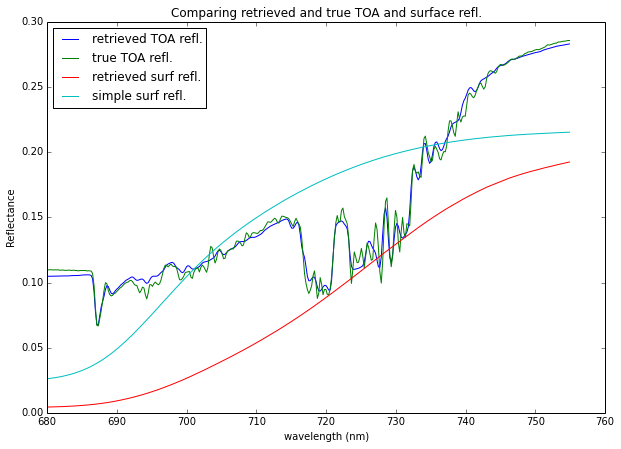

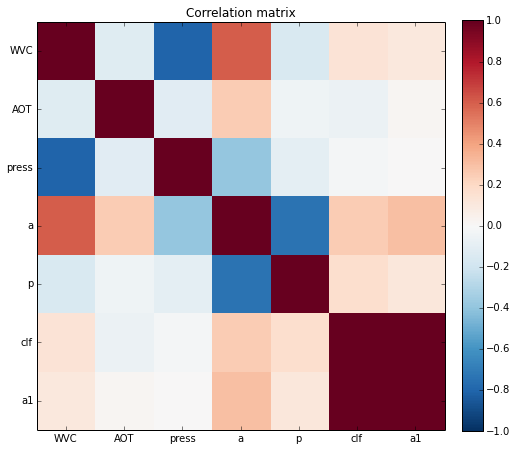

In [59]:
# select sequence number of obs

# select the obs number from this filtered list above
n = 97

# select obs which conform to this less than this clf
clf_thresh = 0.2

ix = np.where(np.array(dic['Cloud_frac']) < clf_thresh)[0]

def raa_fun(sol_azi, sat_azi):
    '''Function to calculate the relative azimuth angle'''
    dif = np.array(sat_azi) - np.array(sol_azi)
    dif = np.where(dif < 0., dif + 360., dif)
    dif = np.where(dif > 180., 360 - dif, dif)
    return dif

i = ix[n]

sza = dic['Sol_zen'][i]
vza = dic['Sat_zen'][i]
sat_azi = dic['Sat_azi'][i]
sol_azi = dic['Sol_azi'][i]
raa = raa_fun(sol_azi, sat_azi)
alt = dic['Alt'][i]/1000. # to km AMSL
toa_refl_gome = dic['Ref_toa'][i]
lam_gome = dic['Lam'][i]
clf_prior = dic['Cloud_frac'][i]

a_prior = 0.5
a_var = 2.0
p_prior = 0.5
p_var = 2.0
a1_prior = -30
a1_var = 10


# load the emulator wavelengths
lam_emu = np.arange(680., 755.05, 0.05)#pickle.load(open(fns, 'rb'))['lam']

# print the lat and lon
lat = dic['Lat'][i]
lon = dic['Lon'][i]
print 'Lat: %.4f, Lon: %.4f' % (lat, lon)
print (lat, lon)


# Read in the raster datasets and get values at coordinate
# January is the Amazon wet season which makes observations relatively difficult althoug Burning Aerosols can be 
# expected to be lower. Thus global average will be used in places with no AOD information.
# load ERA-interim WVC and press datasets of the day to start off
# test these first....

# MODIS AOT daily
fn = '../../Data/MODIS/Combined/MODIS_AOT_combined_grid_day.tiff'

NODATA = -9999

src_ds=gdal.Open(fn)
gt=src_ds.GetGeoTransform()
rb1=src_ds.GetRasterBand(1)
rb2=src_ds.GetRasterBand(2)

px = int((lon - gt[0]) / gt[1]) #x pixel
py = int((lat - gt[3]) / gt[5]) #y pixel

AOT_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
AOT_var=rb2.ReadAsArray(px,py,1,1)[0][0]

# MODIS AOT 8 day
if AOT_prior == -9999:
    fn = '../../Data/MODIS/Combined/MODIS_AOT_combined_grid_8_day.tiff'
    
    src_ds=gdal.Open(fn)
    gt=src_ds.GetGeoTransform()
    rb1=src_ds.GetRasterBand(1)
    rb2=src_ds.GetRasterBand(2)

    px = int((lon - gt[0]) / gt[1]) #x pixel
    py = int((lat - gt[3]) / gt[5]) #y pixel

    AOT_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
    AOT_var=rb2.ReadAsArray(px,py,1,1)[0][0]
    
    # MODIS AOT Monthly
    if AOT_prior == -9999:
        fn = '../../Data/MODIS/Combined/MODIS_AOT_combined_grid_Monthly.tiff'

        src_ds=gdal.Open(fn)
        gt=src_ds.GetGeoTransform()
        rb1=src_ds.GetRasterBand(1)
        rb2=src_ds.GetRasterBand(2)

        px = int((lon - gt[0]) / gt[1]) #x pixel
        py = int((lat - gt[3]) / gt[5]) #y pixel

        AOT_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
        AOT_var=rb2.ReadAsArray(px,py,1,1)[0][0]
        
        # Monthly average
        if AOT_prior == -9999:
            
            AOT_prior = 0.166
            AOT_var = 0.108

if AOT_var == 0.0:
    AOT_var = 0.108
    
AOT_var = AOT_var**2.

# MODIS WVC daily
fn = '../../Data/MODIS/Combined/MODIS_WVC_combined_grid_day.tiff'

NODATA = -9999

src_ds=gdal.Open(fn)
gt=src_ds.GetGeoTransform()
rb1=src_ds.GetRasterBand(1)
rb2=src_ds.GetRasterBand(2)

px = int((lon - gt[0]) / gt[1]) #x pixel
py = int((lat - gt[3]) / gt[5]) #y pixel

WVC_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
WVC_var=rb2.ReadAsArray(px,py,1,1)[0][0]

# MODIS WVC 8 day
if WVC_prior == -9999:
    fn = '../../Data/MODIS/Combined/MODIS_WVC_combined_grid_8_day.tiff'
    
    src_ds=gdal.Open(fn)
    gt=src_ds.GetGeoTransform()
    rb1=src_ds.GetRasterBand(1)
    rb2=src_ds.GetRasterBand(2)

    px = int((lon - gt[0]) / gt[1]) #x pixel
    py = int((lat - gt[3]) / gt[5]) #y pixel

    WVC_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
    WVC_var=rb2.ReadAsArray(px,py,1,1)[0][0]
    
    # MODIS WVC Monthly
    if WVC_prior == -9999:
        fn = '../../Data/MODIS/Combined/MODIS_WVC_combined_grid_monthly.tiff'

        src_ds=gdal.Open(fn)
        gt=src_ds.GetGeoTransform()
        rb1=src_ds.GetRasterBand(1)
        rb2=src_ds.GetRasterBand(2)

        px = int((lon - gt[0]) / gt[1]) #x pixel
        py = int((lat - gt[3]) / gt[5]) #y pixel

        WVC_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
        WVC_var=rb2.ReadAsArray(px,py,1,1)[0][0]

        # ERA-Interim wvc
        if WVC_prior == -9999:
            fn = '../../Data/ERA-Interim/Era_interim_press_wvc.tiff'

            src_ds=gdal.Open(fn)
            gt=src_ds.GetGeoTransform()
            #rb1=src_ds.GetRasterBand(2)
            rb2=src_ds.GetRasterBand(2)

            px = int((lon - gt[0]) / gt[1]) #x pixel
            py = int((lat - gt[3]) / gt[5]) #y pixel

            #press_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
            WVC_prior=rb2.ReadAsArray(px,py,1,1)[0][0]
        
            # Monthly average
            if WVC_prior == -9999:

                WVC_prior = 19.39
                WVC_var = 3.21

WVC_var = WVC_var**2.

# ERA-Interim press
fn = '../../Data/ERA-Interim/Era_interim_press_wvc.tiff'

src_ds=gdal.Open(fn)
gt=src_ds.GetGeoTransform()
rb1=src_ds.GetRasterBand(1)
#rb2=src_ds.GetRasterBand(2)

px = int((lon - gt[0]) / gt[1]) #x pixel
py = int((lat - gt[3]) / gt[5]) #y pixel

press_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
press_var = (10.0)**2

# priors variances are based on the following:
# NCEP and ERA-Interim press unknown...
# FRESCO vs FRESCO+ clf std 0.023 (Tuinder et al 2010) but expected accuracy <10% (Valks et al 2013)

press_var = (10.0)**2
# clf_prior = 0.25
clf_var = (0.05)**2

# round to closest value
szar = int(round(sza, -1))
vzar = int(round(vza, -1))
raas = range(0, 195, 15)
raar = min(raas, key=lambda x:abs(x-raa))

# get gome wavelength interval to correct range
toa_refl_gome = toa_refl_gome[np.logical_and(lam_gome > wl_min, lam_gome < wl_max)]
lam_gome = lam_gome[np.logical_and(lam_gome > wl_min, lam_gome < wl_max)]

# # add the uncorrelated noise
# use convention of SNR = expected signal / std of noise
snr = 1000 # see sources in previous WB

# import cloud PCA
h5_fn = 'cloud_sims.h5'
pca_red_df = pd.read_hdf(h5_fn, key='pca_red_edge')

pca_lam = np.array(pca_red_df.index)
pcas_ = pca_red_df.values.T

# interpolate to gome resolution
pcas = []
for pc in pcas_:
    pcas.append((interp1d(pca_lam, pc, kind='linear'))(lam_gome))
pcas = np.array(pcas)

import gp_emulator
h5_emu = '/home/malapradej/Documents/PhD_UCL/Data/LUT/libradtran_emulators_680-755.h5'
emu = gp_emulator.MultivariateEmulator(dump=h5_emu, model='toa_refl', sza=szar, vza=vzar, raa=raar)
basis = emu.basis_functions

import h5py
h5_mean = h5py.File('/home/malapradej/Documents/PhD_UCL/Data/LUT/mean_signal.h5', 'r')
grp = '%s_%s_%s' % (szar, vzar, raar)
grp = h5_mean[grp]
mean_toa_refl = grp['mean_toa_refl'][:]
mean_toa_lam = np.arange(540., 800.05, 0.05)
mean_toa_refl_emu = (interp1d(mean_toa_lam, mean_toa_refl,kind='linear'))(lam_emu)
mean_toa_refl = (interp1d(mean_toa_lam, mean_toa_refl,kind='linear'))(lam_gome)

def cost(paras, sza, vza, raa, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVCe, WVCv, AOTe, AOTv,\
         presse, pressv, ae, av, pe, pv, clfe, clfv, a1e, a1v):
    '''The cost function to minimize the log of the probabilities
    '''    
    WVC = paras[0]
    AOT = paras[1]
    press = paras[2]
    a = paras[3]
    p = paras[4]
    clf = paras[5]
    a1 = paras[6]
    paras = (WVC, AOT, alt, press, a, p)
    toa_refl_emu = emu.predict(paras)[0] # + mean_toa_refl
    # get refls to same wavelenghts
    # instead of comparing toa refl including cloud need to subtract cloud influence from gome spectra
    # also subtract mean spectra in training data (see notes on 13/12/15)
    toa_refl_comp = (toa_refl_gome - clf*a1*pcas[0]) / (1. - clf) - mean_toa_refl
    # get reflectance to same wavelenghts as the PCs
    lam_gome_ = np.insert(lam_gome, 0, wl_min)
    lam_gome_ = np.append(lam_gome_, wl_max)
    toa_refl_comp_ = np.insert(toa_refl_comp, 0, toa_refl_comp[0])
    toa_refl_comp_ = np.append(toa_refl_comp_, toa_refl_comp[-1])
    toa_refl_comp = (interp1d(lam_gome_, toa_refl_comp_, kind='linear'))(lam_emu)
    # calculate weights of the model and observation
    w = []
    m = []
    for i in range(emu.n_pcs):
        w.append(np.dot(toa_refl_comp, basis[i]))
        m.append(np.dot(toa_refl_emu, basis[i]))
    w = np.array(w)
    m = np.array(m)
    # forward model J term. need to calculate variance of the weights
    modvar = [np.mean(basis[i]**2*toa_refl_comp**2) - np.mean(basis[i]*toa_refl_comp)**2\
              for i in range(emu.n_pcs)]
    modvar = np.array(modvar)
    Jmod = 0.5*np.dot((w - m)**2, 1./modvar)
    # WVC J term
    Jwvc = 0.5*(WVC - WVCe)**2./WVCv
    # AOT J term
    Jaot = 0.5*(AOT - AOTe)**2./AOTv
    # press J term
    Jpress = 0.5*(press - presse)**2./pressv
    # a J term
    Ja = 0.5*(a - ae)**2./av
    # p J term
    Jp = 0.5*(p - pe)**2./pv
    # clf J term
    Jclf = 0.5*(clf - clfe)**2./clfv
    # a1 J term
    Ja1 = 0.5*(a1 - a1e)**2./a1v
    J = Jmod + Jwvc + Jaot + Jpress + Ja + Jp + Jclf + Ja1
    
    return J

args = (szar, vzar, raar, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
         press_prior, press_var, a_prior, a_var, p_prior, p_var, clf_prior, clf_var, a1_prior, a1_var)
#guess = (36., 0.5, 770., 0.4, 0.4, 1.1, 30.) # wvc, aot, press, a, p, clf, a1
guess = (WVC_prior, AOT_prior, press_prior, a_prior, p_prior, clf_prior, a1_prior)
bounds = ((0., 80.), (0., 1.), (500., 1100.), (0., 1.), (0., 1.), (0., 1.), (-10000, 0))
lower = (0., 0., 500., 0., 0., 1., -10000)
upper = (80., 1., 1100., 1., 1., 1000., 0.)
solv_paras = optimize.minimize(cost,guess,jac=False,method='Nelder-Mead',\
                                args=args,bounds=bounds, options={'maxiter': 5000, 'maxfev': 5000})

# show difference between retrieved and true parameters and plot retrieved and true spectra
WVCr = solv_paras['x'][0]
AOTr = solv_paras['x'][1]
pressr = solv_paras['x'][2]
ar = solv_paras['x'][3]
pr = solv_paras['x'][4]
clfr = solv_paras['x'][5]
a0r = 1. / (1. - clfr)
a1r = solv_paras['x'][6]
err = solv_paras['fun']
succ = solv_paras['success']

surf_refl_fun = lambda w, a, p: a * w / (1. - p * w)
dasf_fun = lambda a, p: a / (1. - p)

dasf_pred = dasf_fun(ar, pr)

# do a simple curve fit to get DASF without atm and cloud correction
popt, pcov = optimize.curve_fit(surf_refl_fun, w, toa_refl_gome)
a_s, p_s = popt[0], popt[1]
a_v, p_v = pcov[0,0], pcov[1,1]
dasf_simple = dasf_fun(a_s, p_s)


# calculate the Hessian for the std of the posterior 
import numdifftools as nd
hes = nd.Hessian(cost, full_output=True, method='central')
x = (WVCr, AOTr, pressr, ar, pr, clfr, a1r)
args = (szar, vzar, raar, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
         press_prior, press_var, a_prior, a_var, p_prior, p_var, clf_prior, clf_var, a1_prior, a1_var)
H = hes(x, szar, vzar, raar, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
         press_prior, press_var, a_prior, a_var, p_prior, p_var, clf_prior, clf_var, a1_prior, a1_var)
Cov = np.linalg.inv(H[0])
post_std = np.sqrt(np.diag(Cov))
WVCs, AOTs, presss, ass, ps, clfs, a1s = post_std

# calculate the correlation matrix
D = np.eye(7)*np.sqrt ( Cov.diagonal() )
R = np.linalg.inv ( D )
corr =  R.dot(Cov.dot(R))

toa_refl_pred = emu.predict((WVCr, AOTr, alt, pressr, ar, pr))[0] + mean_toa_refl_emu
toa_refl_pred = (interp1d(lam_emu, toa_refl_pred, kind='linear'))(lam_gome)
toa_refl_pred = (1. - clfr)*toa_refl_pred + clfr*a1r*pcas[0]

# RMSE of obs and model
rmse = np.sqrt(np.sum((toa_refl_pred - toa_refl_gome)**2./len(toa_refl_pred)))

# print values
print 'solver success: %s' % succ
print 'J cost: %.4f' % err
print 'RMSE:   %.4f' % rmse
print 'sza: %s, vza: %s, raa: %s, alt: %s km' % (sza, vza, raa, alt)
print '-'*50
print 'Prior parameters (mean, std)'
print 'clf: %5.4f, AOT: %5.4f, WVC: %7.4f kg/m2, press: %9.4f hPa, a:  %5.4f,    p: %5.4f' % \
        (clf_prior, AOT_prior, WVC_prior, press_prior, a_prior, p_prior)
print 'std: %5.4f, std: %5.4f, std: %7.4f kg/m2, std:   %9.4f hPa,std: %5.4f,  std: %5.4f' % \
        (np.sqrt(clf_var), np.sqrt(AOT_var), np.sqrt(WVC_var), np.sqrt(press_var), np.sqrt(a_var), np.sqrt(p_var))
print '-'*50
print 'Retrieved parameters (mean, std)'
print 'clf: %5.4f, AOT: %5.4f, WVC: %7.4f kg/m2, press: %9.4f hPa, a:   %5.4f,   p: %5.4f, DASF: %5.4f' % \
    (clfr, AOTr, WVCr, pressr, ar, pr, dasf_pred)
print 'std: %5.4f, std: %5.4f, std: %7.4f kg/m2, std:   %9.4f hPa,std:  %5.4f, std: %5.4f' % \
        (clfs, AOTs, WVCs, presss, ass, ps )
print '-'*50
print 'Simple solution (mean, std)'
print ' '*67, 'a:   %5.4f,   p: %5.4f, DASF: %5.4f' % (a_s, p_s, dasf_simple)
print ' '*66, 'std:  %5.4f, std: %5.4f' % (np.sqrt(a_v), np.sqrt(p_v))
print '-'*50
#print solv_paras

# plot the spectra true and retrieved
plt.figure(figsize=(10,7))
plt.plot(lam_gome, toa_refl_pred, label='retrieved TOA refl.')
plt.plot(lam_gome, toa_refl_gome, label='true TOA refl.')
leafw = np.loadtxt('leaf_spectrum.txt')
lam_leaf = leafw[:,0]
leafw = leafw[:,1] + leafw[:,2]
w = (interp1d(lam_leaf, leafw, kind='linear'))(lam_gome)
surf_refl_retr = surf_refl_fun(w, ar, pr)
surf_refl_simple = surf_refl_fun(w, a_s, p_s)
plt.plot(lam_gome, surf_refl_retr, label='retrieved surf refl.')
plt.plot(lam_gome, surf_refl_simple, label='simple surf refl.')
plt.title('Comparing retrieved and true TOA and surface refl.')
plt.legend(loc='best')
plt.xlabel('wavelength (nm)')
plt.ylabel('Reflectance')

# plot the correlation matrix
plt.figure(figsize=(8,8))
plt.imshow(corr,interpolation='nearest', cmap=plt.cm.RdBu_r, vmax=1, vmin=-1)
plt.title('Correlation matrix')
plt.xticks(np.arange(0.,7.,1),['WVC', 'AOT', 'press', 'a', 'p', 'clf', 'a1'])
plt.yticks(np.arange(0.,7.,1),['WVC', 'AOT', 'press', 'a', 'p', 'clf', 'a1'])
plt.colorbar(fraction=0.046, pad=0.04)
print 'Correlation matrix'
print corr

## Retrieve Amazon dataset

In [32]:
# open the pickled dict of observations created before

import sys
import gdal
import os
from scipy import optimize
from scipy.interpolate import interp1d
import pickle
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
import pdb

# to range we need
wl_min = 680
wl_max = 755

# path to EPS file to read
e_fn = '/home/malapradej/Documents/PhD_UCL/Data/GOME-2/l1b/2007/01/GOME_xxx_1B_M02_20070125124939Z_20070125143057Z_R_O_20120209112017Z'

path = '/home/malapradej/Documents/PhD_UCL/Data/GOME-2/DASF'
base = os.path.splitext(e_fn)[0]
base = os.path.basename(base)
base = os.path.join(path, base)
ext =  '_EPS_QAd.p'
path = os.path.join(path, base + ext)

dic = pickle.load(open(path, 'rb'))

In [25]:
# # create subset of dictionary for faster testing
# n = 3
# dicsub = {}
# for keys, values in dic.iteritems():
#     dicsub[keys] = values[0:n]
# dic = dicsub

2.0

#### 

In [33]:
a_prior = 0.5
a_var = np.float64(2.0)
p_prior = 0.5
p_var = np.float64(2.0)
a1_prior = -30
a1_var = 10

# priors variances are based on the following:
# NCEP and ERA-Interim press unknown...
# FRESCO vs FRESCO+ clf std 0.023 (Tuinder et al 2010) but expected accuracy <10% (Valks et al 2013)
press_var = np.float64((10.0)**2)
clf_var = (0.05)**2

# # add the uncorrelated noise
# use convention of SNR = expected signal / std of noise
snr = 1000 # see sources in previous WB

# import cloud PCA
h5_fn = 'cloud_sims.h5'
pca_red_df = pd.read_hdf(h5_fn, key='pca_red_edge')

pca_lam = np.array(pca_red_df.index)
pcas_ = pca_red_df.values.T

# load leaf spectra
leafw = np.loadtxt('leaf_spectrum.txt')
lam_leaf = leafw[:,0]
leafw = leafw[:,1] + leafw[:,2]

# load the emulator wavelengths
lam_emu = np.arange(680., 755.05, 0.05)

def raa_fun(sol_azi, sat_azi):
    '''Function to calculate the relative azimuth angle'''
    dif = np.array(sat_azi) - np.array(sol_azi)
    dif = np.where(dif < 0., dif + 360., dif)
    dif = np.where(dif > 180., 360 - dif, dif)
    dif = np.float64(dif)
    return dif

import ogr,osr
    
# We need the output projection to bet set to Lat/Long
latlong = osr.SpatialReference()
latlong.ImportFromEPSG( 4326 )

# Invoke the GeoJSON driver
drv = ogr.GetDriverByName('ESRI Shapefile')
# This is the output filename
fn_json = '%s_DASF.shp' % os.path.splitext(os.path.basename(e_fn))[0]
fn_json = os.path.join(os.path.dirname(path), fn_json)

# if the file exists delete it
# Remove output shapefile if it already exists
if os.path.exists(fn_json):
    drv.DeleteDataSource(fn_json)

# if os.path.exists(fn_json):
#     os.remove(fn_json)
    
dst_ds = drv.CreateDataSource(fn_json)
# This is the layer of the dataset. The layer needs to be of points
# and needs to have the WGS84 projection, which we defined above
dst_layer = dst_ds.CreateLayer('', srs =latlong , \
                               geom_type=ogr.wkbPoint )

# We just need a field with a name, and its type
field_dic_dtypes = {'success':ogr.OFTInteger, 'rmse':ogr.OFTReal, 'a':ogr.OFTReal, 'p':ogr.OFTReal,\
            'DASF':ogr.OFTReal, 'a_std':ogr.OFTReal, 'p_std':ogr.OFTReal, 'a_prior':ogr.OFTReal,\
            'p_prior':ogr.OFTReal, 'a_prior_sd':ogr.OFTReal, 'p_prior_sd':ogr.OFTReal, \
            'lat':ogr.OFTReal, 'lon':ogr.OFTReal, 'a_easy':ogr.OFTReal, 'p_easy':ogr.OFTReal,\
            'a_easy_std':ogr.OFTReal, 'p_easy_std':ogr.OFTReal, 'DASF_easy':ogr.OFTReal,\
            'Jcost':ogr.OFTReal, 'sza':ogr.OFTReal, 'vza':ogr.OFTReal, 'raa':ogr.OFTReal,\
            'alt':ogr.OFTReal, 'wvc':ogr.OFTReal, 'aot':ogr.OFTReal, 'press':ogr.OFTReal,\
            'wvc_std':ogr.OFTReal, 'aot_std':ogr.OFTReal, 'press_std':ogr.OFTReal, 'clf':ogr.OFTReal,\
            'clf_std':ogr.OFTReal, 'a1':ogr.OFTReal, 'a1_std':ogr.OFTReal, 'wvc_prior':ogr.OFTReal,\
            'aot_prior':ogr.OFTReal, 'pres_prior':ogr.OFTReal, 'a1_prior':ogr.OFTReal,\
            'clf_prior':ogr.OFTReal, 'wvc_pr_std':ogr.OFTReal, 'aot_pr_std':ogr.OFTReal,\
            'pres_pr_sd':ogr.OFTReal, 'clf_pr_std':ogr.OFTReal, 'a1_pr_std':ogr.OFTReal,\
            'Time':ogr.OFTReal}

keys = ['Time', 'aot_std', 'sza', 'lat', 'alt', 'clf', 'lon', 'a_easy', 'DASF_easy', 'p_prior', 'press',\
        'wvc', 'DASF', 'a1_std', 'success', 'rmse', 'p_std', 'p', 'wvc_pr_std', 'p_easy', 'Jcost', 'a_std',\
        'raa', 'wvc_prior', 'clf_pr_std', 'p_prior_sd', 'vza', 'pres_prior', 'clf_prior', 'a_easy_std', \
        'a1_pr_std', 'a1', 'pres_pr_sd', 'aot', 'clf_std', 'aot_pr_std', 'a', 'a_prior_sd', 'a1_prior',\
        'aot_prior', 'press_std', 'a_prior', 'p_easy_std', 'wvc_std']

# We just need to create the field, and its type
for key in keys:
    field_defn=ogr.FieldDefn(key, field_dic_dtypes[key])
    dst_layer.CreateField( field_defn )

# loop over all values in dic
for j in range(len(dic['Alt'])):
    time = dic['Time'][j]
    sza = dic['Sol_zen'][j]
    vza = dic['Sat_zen'][j]
    sat_azi = dic['Sat_azi'][j]
    sol_azi = dic['Sol_azi'][j]
    raa = raa_fun(sol_azi, sat_azi)
    alt = dic['Alt'][j]/1000. # to km AMSL
    toa_refl_gome = dic['Ref_toa'][j]
    lam_gome = dic['Lam'][j]
    clf_prior = dic['Cloud_frac'][j]
    lat = dic['Lat'][j]
    lon = dic['Lon'][j]

    # Read in the raster datasets and get values at coordinate
    # January is the Amazon wet season which makes observations relatively difficult althoug Burning Aerosols can be 
    # expected to be lower. Thus global average will be used in places with no AOD information.
    # load ERA-interim WVC and press datasets of the day to start off
    # test these first....

    # MODIS AOT daily
    fn = '../../Data/MODIS/Combined/MODIS_AOT_combined_grid_day.tiff'

    NODATA = -9999

    src_ds=gdal.Open(fn)
    gt=src_ds.GetGeoTransform()
    rb1=src_ds.GetRasterBand(1)
    rb2=src_ds.GetRasterBand(2)

    px = int((lon - gt[0]) / gt[1]) #x pixel
    py = int((lat - gt[3]) / gt[5]) #y pixel

    AOT_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
    AOT_var=rb2.ReadAsArray(px,py,1,1)[0][0]

    # MODIS AOT 8 day
    if AOT_prior == -9999:
        fn = '../../Data/MODIS/Combined/MODIS_AOT_combined_grid_8_day.tiff'

        src_ds=gdal.Open(fn)
        gt=src_ds.GetGeoTransform()
        rb1=src_ds.GetRasterBand(1)
        rb2=src_ds.GetRasterBand(2)

        px = int((lon - gt[0]) / gt[1]) #x pixel
        py = int((lat - gt[3]) / gt[5]) #y pixel

        AOT_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
        AOT_var=rb2.ReadAsArray(px,py,1,1)[0][0]

        # MODIS AOT Monthly
        if AOT_prior == -9999:
            fn = '../../Data/MODIS/Combined/MODIS_AOT_combined_grid_Monthly.tiff'

            src_ds=gdal.Open(fn)
            gt=src_ds.GetGeoTransform()
            rb1=src_ds.GetRasterBand(1)
            rb2=src_ds.GetRasterBand(2)

            px = int((lon - gt[0]) / gt[1]) #x pixel
            py = int((lat - gt[3]) / gt[5]) #y pixel

            AOT_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
            AOT_var=rb2.ReadAsArray(px,py,1,1)[0][0]

            # Monthly average
            if AOT_prior == -9999:

                AOT_prior = 0.166
                AOT_var = 0.108

    if AOT_var == 0.0:
        AOT_var = 0.108
    
    AOT_prior = np.float64(AOT_prior)
    AOT_var = np.float64(AOT_var**2.)

    # MODIS WVC daily
    fn = '../../Data/MODIS/Combined/MODIS_WVC_combined_grid_day.tiff'

    NODATA = -9999

    src_ds=gdal.Open(fn)
    gt=src_ds.GetGeoTransform()
    rb1=src_ds.GetRasterBand(1)
    rb2=src_ds.GetRasterBand(2)

    px = int((lon - gt[0]) / gt[1]) #x pixel
    py = int((lat - gt[3]) / gt[5]) #y pixel

    WVC_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
    WVC_var=rb2.ReadAsArray(px,py,1,1)[0][0]

    # MODIS WVC 8 day
    if WVC_prior == -9999:
        fn = '../../Data/MODIS/Combined/MODIS_WVC_combined_grid_8_day.tiff'

        src_ds=gdal.Open(fn)
        gt=src_ds.GetGeoTransform()
        rb1=src_ds.GetRasterBand(1)
        rb2=src_ds.GetRasterBand(2)

        px = int((lon - gt[0]) / gt[1]) #x pixel
        py = int((lat - gt[3]) / gt[5]) #y pixel

        WVC_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
        WVC_var=rb2.ReadAsArray(px,py,1,1)[0][0]

        # MODIS WVC Monthly
        if WVC_prior == -9999:
            fn = '../../Data/MODIS/Combined/MODIS_WVC_combined_grid_monthly.tiff'

            src_ds=gdal.Open(fn)
            gt=src_ds.GetGeoTransform()
            rb1=src_ds.GetRasterBand(1)
            rb2=src_ds.GetRasterBand(2)

            px = int((lon - gt[0]) / gt[1]) #x pixel
            py = int((lat - gt[3]) / gt[5]) #y pixel

            WVC_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
            WVC_var=rb2.ReadAsArray(px,py,1,1)[0][0]

            # ERA-Interim wvc
            if WVC_prior == -9999:
                fn = '../../Data/ERA-Interim/Era_interim_press_wvc.tiff'

                src_ds=gdal.Open(fn)
                gt=src_ds.GetGeoTransform()
                #rb1=src_ds.GetRasterBand(2)
                rb2=src_ds.GetRasterBand(2)

                px = int((lon - gt[0]) / gt[1]) #x pixel
                py = int((lat - gt[3]) / gt[5]) #y pixel

                #press_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
                WVC_prior=rb2.ReadAsArray(px,py,1,1)[0][0]

                # Monthly average
                if WVC_prior == -9999:

                    WVC_prior = 19.39
                    WVC_var = 3.21
    
    WVC_prior = np.float64(WVC_prior)
    WVC_var = np.float64(WVC_var**2.)

    # ERA-Interim press
    fn = '../../Data/ERA-Interim/Era_interim_press_wvc.tiff'

    src_ds=gdal.Open(fn)
    gt=src_ds.GetGeoTransform()
    rb1=src_ds.GetRasterBand(1)
    
    px = int((lon - gt[0]) / gt[1]) #x pixel
    py = int((lat - gt[3]) / gt[5]) #y pixel

    press_prior=np.float64(rb1.ReadAsArray(px,py,1,1)[0][0])

    # round to closest value
    szar = int(round(sza, -1))
    vzar = int(round(vza, -1))
    raas = range(0, 195, 15)
    raar = min(raas, key=lambda x:abs(x-raa))

    # get gome wavelength interval to correct range
    toa_refl_gome = toa_refl_gome[np.logical_and(lam_gome > wl_min, lam_gome < wl_max)]
    lam_gome = lam_gome[np.logical_and(lam_gome > wl_min, lam_gome < wl_max)]

    # interpolate to gome resolution
    pcas = []
    for pc in pcas_:
        pcas.append((interp1d(pca_lam, pc, kind='linear'))(lam_gome))
    pcas = np.array(pcas)

    import gp_emulator
    h5_emu = '/home/malapradej/Documents/PhD_UCL/Data/LUT/libradtran_emulators_680-755.h5'
    emu = gp_emulator.MultivariateEmulator(dump=h5_emu, model='toa_refl', sza=szar, vza=vzar, raa=raar)
    basis = emu.basis_functions

    import h5py
    h5_mean = h5py.File('/home/malapradej/Documents/PhD_UCL/Data/LUT/mean_signal.h5', 'r')
    grp = '%s_%s_%s' % (szar, vzar, raar)
    grp = h5_mean[grp]
    mean_toa_refl = grp['mean_toa_refl'][:]
    mean_toa_lam = np.arange(540., 800.05, 0.05)
    mean_toa_refl_emu = (interp1d(mean_toa_lam, mean_toa_refl,kind='linear'))(lam_emu)
    mean_toa_refl = (interp1d(mean_toa_lam, mean_toa_refl,kind='linear'))(lam_gome)

    def cost(paras, sza, vza, raa, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVCe, WVCv, AOTe, AOTv,\
             presse, pressv, ae, av, pe, pv, clfe, clfv, a1e, a1v):
        '''The cost function to minimize the log of the probabilities
        '''    
        WVC = paras[0]
        AOT = paras[1]
        press = paras[2]
        a = paras[3]
        p = paras[4]
        clf = paras[5]
        a1 = paras[6]
        paras = (WVC, AOT, alt, press, a, p)
        toa_refl_emu = emu.predict(paras)[0] # + mean_toa_refl
        # get refls to same wavelenghts
        # instead of comparing toa refl including cloud need to subtract cloud influence from gome spectra
        # also subtract mean spectra in training data (see notes on 13/12/15)
        toa_refl_comp = (toa_refl_gome - clf*a1*pcas[0]) / (1. - clf) - mean_toa_refl
        # get reflectance to same wavelenghts as the PCs
        lam_gome_ = np.insert(lam_gome, 0, wl_min)
        lam_gome_ = np.append(lam_gome_, wl_max)
        toa_refl_comp_ = np.insert(toa_refl_comp, 0, toa_refl_comp[0])
        toa_refl_comp_ = np.append(toa_refl_comp_, toa_refl_comp[-1])
        toa_refl_comp = (interp1d(lam_gome_, toa_refl_comp_, kind='linear'))(lam_emu)
        # calculate weights of the model and observation
        w = []
        m = []
        for i in range(emu.n_pcs):
            w.append(np.dot(toa_refl_comp, basis[i]))
            m.append(np.dot(toa_refl_emu, basis[i]))
        w = np.array(w)
        m = np.array(m)
        # forward model J term. need to calculate variance of the weights
        modvar = [np.mean(basis[i]**2*toa_refl_comp**2) - np.mean(basis[i]*toa_refl_comp)**2\
                  for i in range(emu.n_pcs)]
        modvar = np.array(modvar)
        Jmod = 0.5*np.dot((w - m)**2, 1./modvar)
        # WVC J term
        Jwvc = 0.5*(WVC - WVCe)**2./WVCv
        # AOT J term
        Jaot = 0.5*(AOT - AOTe)**2./AOTv
        # press J term
        Jpress = 0.5*(press - presse)**2./pressv
        # a J term
        Ja = 0.5*(a - ae)**2./av
        # p J term
        Jp = 0.5*(p - pe)**2./pv
        # clf J term
        Jclf = 0.5*(clf - clfe)**2./clfv
        # a1 J term
        Ja1 = 0.5*(a1 - a1e)**2./a1v
        J = Jmod + Jwvc + Jaot + Jpress + Ja + Jp + Jclf + Ja1

        return J

    args = (szar, vzar, raar, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
             press_prior, press_var, a_prior, a_var, p_prior, p_var, clf_prior, clf_var, a1_prior, a1_var)
    guess = (WVC_prior, AOT_prior, press_prior, a_prior, p_prior, clf_prior, a1_prior)
    bounds = ((0., 80.), (0., 1.), (500., 1100.), (0., 1.), (0., 1.), (0., 1.), (-10000, 0))
    lower = (0., 0., 500., 0., 0., 1., -10000)
    upper = (80., 1., 1100., 1., 1., 1000., 0.)
    solv_paras = optimize.minimize(cost,guess,jac=False,method='Nelder-Mead',\
                                    args=args,bounds=bounds, options={'maxiter': 5000, 'maxfev': 5000})

    # show difference between retrieved and true parameters and plot retrieved and true spectra
    WVCr = solv_paras['x'][0]
    AOTr = solv_paras['x'][1]
    pressr = solv_paras['x'][2]
    ar = solv_paras['x'][3]
    pr = solv_paras['x'][4]
    clfr = solv_paras['x'][5]
    a0r = 1. / (1. - clfr)
    a1r = solv_paras['x'][6]
    err = solv_paras['fun']
    succ = solv_paras['success']

    surf_refl_fun = lambda w, a, p: a * w / (1. - p * w)
    dasf_fun = lambda a, p: a / (1. - p)

    dasf_pred = dasf_fun(ar, pr)
    
    w = (interp1d(lam_leaf, leafw, kind='linear'))(lam_gome)

    # do a simple curve fit to get DASF without atm and cloud correction
    popt, pcov = optimize.curve_fit(surf_refl_fun, w, toa_refl_gome)
    a_s, p_s = popt[0], popt[1]
    a_v, p_v = pcov[0,0], pcov[1,1]
    dasf_simple = dasf_fun(a_s, p_s)

    # calculate the Hessian for the std of the posterior 
    import numdifftools as nd
    hes = nd.Hessian(cost, full_output=True, method='central')
    x = (WVCr, AOTr, pressr, ar, pr, clfr, a1r)
    args = (szar, vzar, raar, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
             press_prior, press_var, a_prior, a_var, p_prior, p_var, clf_prior, clf_var, a1_prior, a1_var)
    H = hes(x, szar, vzar, raar, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
             press_prior, press_var, a_prior, a_var, p_prior, p_var, clf_prior, clf_var, a1_prior, a1_var)
    Cov = np.linalg.inv(H[0])
    post_std = np.sqrt(np.diag(Cov))
    WVCs, AOTs, presss, ass, ps, clfs, a1s = post_std

#     # calculate the correlation matrix
#     D = np.eye(7)*np.sqrt ( Cov.diagonal() )
#     R = np.linalg.inv ( D )
#     corr =  R.dot(Cov.dot(R))
    
    toa_refl_pred = emu.predict((WVCr, AOTr, alt, pressr, ar, pr))[0] + mean_toa_refl_emu
    toa_refl_pred = (interp1d(lam_emu, toa_refl_pred, kind='linear'))(lam_gome)
    toa_refl_pred = (1. - clfr)*toa_refl_pred + clfr*a1r*pcas[0]
    
    # RMSE of obs and model
    rmse = np.sqrt(np.sum((toa_refl_pred - toa_refl_gome)**2./len(toa_refl_pred)))
    
    # save data to shapefile
    # data to save - a, p for simple and retrieved solution and their prior and post var; solver success, rmse and J cost; 
    # sza, vza, raa, lat, lon, and alt; wvc, aot, press, clf and a1 for prior and retrieved solution and their 
    # prior and post variances; lam_gome, toa_refl_pred and toa_refl_gome; 
    # date and time would be additional information from multiday and orbit datasets
    
    if succ:
        succ = 1
    else:
        succ = 0
    
    field_dic_vals = {'success':succ, 'rmse':rmse, 'a':ar, 'p':pr,\
            'DASF':dasf_pred, 'a_std':ass, 'p_std':ps, 'a_prior':a_prior,\
            'p_prior':p_prior, 'a_prior_sd':np.sqrt(a_var), 'p_prior_sd':np.sqrt(p_var), \
            'lat':lat, 'lon':lon, 'a_easy':a_s, 'p_easy':p_s,\
            'a_easy_std':np.sqrt(a_v), 'p_easy_std':np.sqrt(p_v), 'DASF_easy':dasf_simple,\
            'Jcost':err, 'sza':sza, 'vza':vza, 'raa':raa,\
            'alt':alt, 'wvc':WVCr, 'aot':AOTr, 'press':pressr,\
            'wvc_std':WVCs, 'aot_std':AOTs, 'press_std':presss, 'clf':clfr,\
            'clf_std':clfs, 'a1':a1r, 'a1_std':a1s, 'wvc_prior':WVC_prior,\
            'aot_prior':AOT_prior, 'pres_prior':press_prior, 'a1_prior':a1_prior,\
            'clf_prior':clf_prior, 'wvc_pr_std':np.sqrt(WVC_var), 'aot_pr_std':np.sqrt(AOT_var),\
            'pres_pr_sd':np.sqrt(press_var), 'clf_pr_std':np.sqrt(clf_var), 'a1_pr_std':np.sqrt(a1_var),\
            'Time':time}

    keys = ['Time', 'aot_std', 'sza', 'lat', 'alt', 'clf', 'lon', 'a_easy', 'DASF_easy', 'p_prior', 'press',\
            'wvc', 'DASF', 'a1_std', 'success', 'rmse', 'p_std', 'p', 'wvc_pr_std', 'p_easy', 'Jcost', 'a_std',\
            'raa', 'wvc_prior', 'clf_pr_std', 'p_prior_sd', 'vza', 'pres_prior', 'clf_prior', 'a_easy_std', \
            'a1_pr_std', 'a1', 'pres_pr_sd', 'aot', 'clf_std', 'aot_pr_std', 'a', 'a_prior_sd', 'a1_prior',\
            'aot_prior', 'press_std', 'a_prior', 'p_easy_std', 'wvc_std']
    
    wkt = "POINT ( %f %f )" % (lon, lat)
    # Create a feature, using the attributes/fields that are
    # required for this layer
    feat = ogr.Feature(feature_def=dst_layer.GetLayerDefn())
    # Feed the WKT into a geometry
    p = ogr.CreateGeometryFromWkt(wkt)
    # Feed the geometry into a WKT
    feat.SetGeometryDirectly(p)
    # Set the name field to its value
    for key in keys:
#         pdb.set_trace()
        feat.SetField (key, field_dic_vals[key])
#     pdb.set_trace()
    # Attach the feature to the layer
    dst_layer.CreateFeature(feat)
    # Clean up
    feat.Destroy()
    
dst_ds = None
print 'shapefile created.'
#     # print values
#     print 'solver success: %s' % succ
#     print 'cost: %.4f' % err
#     print 'sza: %s, vza: %s, raa: %s, alt: %s km' % (sza, vza, raa, alt)
#     print '-'*50
#     print 'Prior parameters (mean, std)'
#     print 'clf: %5.4f, AOT: %5.4f, WVC: %7.4f kg/m2, press: %9.4f hPa, a:  %5.4f,    p: %5.4f' % \
#             (clf_prior, AOT_prior, WVC_prior, press_prior, a_prior, p_prior)
#     print 'std: %5.4f, std: %5.4f, std: %7.4f kg/m2, std:   %9.4f hPa,std: %5.4f,  std: %5.4f' % \
#             (np.sqrt(clf_var), np.sqrt(AOT_var), np.sqrt(WVC_var), np.sqrt(press_var), np.sqrt(a_var), np.sqrt(p_var))
#     print '-'*50
#     print 'Retrieved parameters (mean, std)'
#     print 'clf: %5.4f, AOT: %5.4f, WVC: %7.4f kg/m2, press: %9.4f hPa, a:   %5.4f,   p: %5.4f, DASF: %5.4f' % \
#         (clfr, AOTr, WVCr, pressr, ar, pr, dasf_pred)
#     print 'std: %5.4f, std: %5.4f, std: %7.4f kg/m2, std:   %9.4f hPa,std:  %5.4f, std: %5.4f' % \
#             (clfs, AOTs, WVCs, presss, ass, ps )
#     print '-'*50
#     print 'Simple solution (mean, std)'
#     print ' '*67, 'a:   %5.4f,   p: %5.4f, DASF: %5.4f' % (a_s, p_s, dasf_simple)
#     print ' '*66, 'std:  %5.4f, std: %5.4f' % (np.sqrt(a_v), np.sqrt(p_v))
#     print '-'*50
#     #print solv_paras

#     # plot the spectra true and retrieved
#     toa_refl_pred = emu.predict((WVCr, AOTr, alt, pressr, ar, pr))[0] + mean_toa_refl_emu
#     toa_refl_pred = (interp1d(lam_emu, toa_refl_pred, kind='linear'))(lam_gome)
#     toa_refl_pred = (1. - clfr)*toa_refl_pred + clfr*a1r*pcas[0]
#     plt.figure(figsize=(10,7))
#     plt.plot(lam_gome, toa_refl_pred, label='retrieved TOA refl.')
#     plt.plot(lam_gome, toa_refl_gome, label='true TOA refl.')
#     leafw = np.loadtxt('leaf_spectrum.txt')
#     lam_leaf = leafw[:,0]
#     leafw = leafw[:,1] + leafw[:,2]
#     w = (interp1d(lam_leaf, leafw, kind='linear'))(lam_gome)
#     surf_refl_retr = surf_refl_fun(w, ar, pr)
#     surf_refl_simple = surf_refl_fun(w, a_s, p_s)
#     plt.plot(lam_gome, surf_refl_retr, label='retrieved surf refl.')
#     plt.plot(lam_gome, surf_refl_simple, label='simple surf refl.')
#     plt.title('Comparing retrieved and true TOA and surface refl.')
#     plt.legend(loc='best')
#     plt.xlabel('wavelength (nm)')
#     plt.ylabel('Reflectance')

#     # plot the correlation matrix
#     plt.figure(figsize=(8,8))
#     plt.imshow(corr,interpolation='nearest', cmap=plt.cm.RdBu_r, vmax=1, vmin=-1)
#     plt.title('Correlation matrix')
#     plt.xticks(np.arange(0.,7.,1),['WVC', 'AOT', 'press', 'a', 'p', 'clf', 'a1'])
#     plt.yticks(np.arange(0.,7.,1),['WVC', 'AOT', 'press', 'a', 'p', 'clf', 'a1'])
#     plt.colorbar(fraction=0.046, pad=0.04)
#     print 'Correlation matrix'
#     print corr


shapefile created.


In [13]:
np.sqrt(a_var)

1.4142135623730951

In [19]:
np.sqrt()

3.7109512593475644

In [21]:
type(press_var)

float

In [22]:
type(presss)

numpy.float64

In [49]:
feat.SetFieldDoubleList()

TypeError: Feature_SetFieldDoubleList() takes exactly 3 arguments (1 given)

In [12]:
field_dic_vals.values()

[0.10799999999966498,
 48.026271,
 -10.664573,
 0.179,
 0.037359976163399991,
 -66.790786,
 14.432510973656761,
 0.52246789509072289,
 0.5,
 1169731386.984,
 991.16871704959317,
 47.384092030749486,
 -0.91729454151680012,
 0.063534067149154203,
 1,
 0.066970506728286722,
 1.4142135623682641,
 -12.766673982555375,
 0.4400000274181366,
 -26.623727906095848,
 1266181.6754478975,
 1.4142135620361789,
 1.8630810000000224,
 47.280002593994141,
 0.050000000000000003,
 1.4142135623730951,
 47.522796,
 990.629638671875,
 0.658872,
 1.8871595000144159,
 3.1622776601683795,
 -326.8988590273288,
 10.0,
 0.50715406194115364,
 0.014574688001015215,
 0.108,
 -12.628094899039393,
 1.4142135623730951,
 -30,
 0.2330000102519989,
 10.000000001728521,
 0.5,
 3.7109512593475644,
 0.44000002741913352]

In [9]:
field_dic_vals = {'success':succ, 'rmse':rmse, 'a':ar, 'p':pr,\
            'DASF':dasf_pred, 'a_std':ass, 'p_std':ps, 'a_prior':a_prior,\
            'p_prior':p_prior, 'a_prior_sd':np.sqrt(a_var), 'p_prior_sd':np.sqrt(p_var), \
            'lat':lat, 'lon':lon, 'a_easy':a_s, 'p_easy':p_s,\
            'a_easy_std':np.sqrt(a_v), 'p_easy_std':np.sqrt(p_v), 'DASF_easy':dasf_simple,\
            'Jcost':err, 'sza':sza, 'vza':vza, 'raa':raa,\
            'alt':alt, 'wvc':WVCr, 'aot':AOTr, 'press':pressr,\
            'wvc_std':WVCs, 'aot_std':AOTs, 'press_std':presss, 'clf':clfr,\
            'clf_std':clfs, 'a1':a1r, 'a1_std':a1s, 'wvc_prior':WVC_prior,\
            'aot_prior':AOT_prior, 'pres_prior':press_prior, 'a1_prior':a1_prior,\
            'clf_prior':clf_prior, 'wvc_pr_std':np.sqrt(WVC_var), 'aot_pr_std':np.sqrt(AOT_var),\
            'pres_pr_std':np.sqrt(press_var), 'clf_pr_std':np.sqrt(clf_var), 'a1_pr_std':np.sqrt(a1_var),\
            'Time':time}

aot_std
sza
lat
alt
clf
lon
a_easy
DASF_easy
p_prior
Time
press
wvc
DASF
a1_std
success
rmse
p_std
p
wvc_pr_std
p_easy
Jcost
a_std
raa
wvc_prior
clf_pr_std
p_prior_std
vza
pres_prior
clf_prior
a_easy_std
a1_pr_std
a1
pres_pr_std
aot
clf_std
aot_pr_std
a
a_prior_std
a1_prior
aot_prior
press_std
a_prior
p_easy_std
wvc_std
